In [ ]:
from glob import glob
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/MyDrive/YOLO v8 models/Healthy vs diseased/binary classifier(healthy vs disease)/'

runs  train  train.cache  val  val.cache


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Data preparation (replace with your actual paths)
train_data_dir = '/content/gdrive/MyDrive/YOLO v8 models/Healthy vs diseased/binary classifier(healthy vs disease)/train'
validation_data_dir = '/content/gdrive/MyDrive/YOLO v8 models/Healthy vs diseased/binary classifier(healthy vs disease)/val/'
image_size = (640, 640)  # Input size for ResNet50
batch_size = 32

In [ ]:
# Create data generators with proper class_mode
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)


Found 7251 files belonging to 2 classes.


In [ ]:
validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)

Found 2079 files belonging to 2 classes.


In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
input_shape=(640,640,3),
pooling='avg',classes=2,
weights='imagenet')
for layer in pretrained_model.layers:
  layer.trainable=False


resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))  # Existing layer
#dnn_model.add(Dense(units=512, activation='relu'))  # New layer to adjust shape
resnet_model.add(Dense(1, activation='sigmoid'))

In [ ]:
resnet_model.summary()

In [ ]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = resnet_model.fit(
train_generator,
validation_data=validation_generator,
epochs=100
)

In [ ]:
from tensorflow.keras.models import save_model

# Save the model after training
resnet_model.save('/content/gdrive/MyDrive/YOLO v8 models/Healthy vs diseased/binary classifier(healthy vs disease)/resnet50_100/')


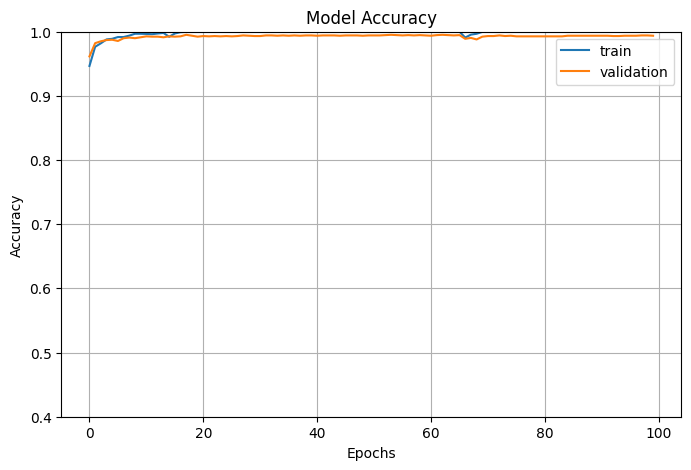

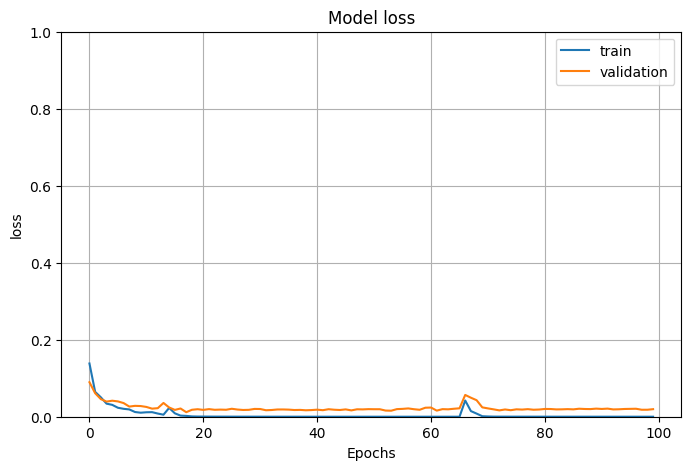

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

epochs = len(history.history['accuracy'])  # Get the number of epochs from history

epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('Training vs Validation Accuracy.jpg')
plt.show()

plt.figure(figsize=(8, 5))

plt.plot(epochs_range, history.history['loss'], label="Training loss")
plt.plot(epochs_range, history.history['val_loss'], label="Validation loss")
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('Training vs Validation Loss')
plt.show()


In [ ]:
import pathlib
test_directory = pathlib.Path('/content/gdrive/MyDrive/YOLO v8 models/Healthy vs diseased/Test data')
class_labels = [str(folder.name) for folder in test_directory.glob('*/')]

In [ ]:
test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    shuffle=False
)



Found 1000 files belonging to 2 classes.


In [ ]:
# Get predictions on the validation set
predictions = resnet_model.predict(test_generator)
predictions_classes = np.argmax(predictions, axis=1)  # Get class indices

# Get true labels (also convert to class indices for compatibility)
true_labels = np.concatenate([y for x, y in test_generator], axis=0)
true_labels_classes = np.argmax(true_labels, axis=1)


32/32 [==============================] - 104s 3s/step


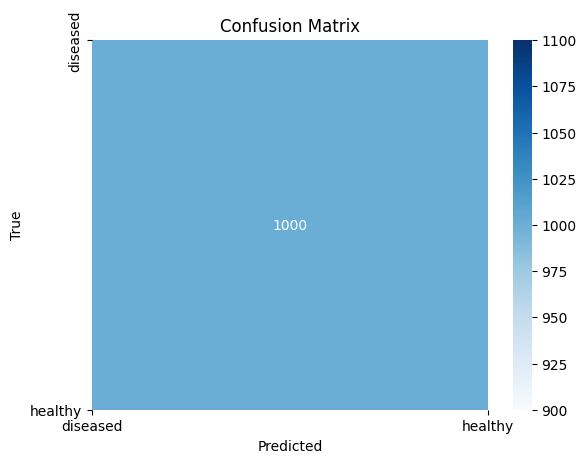

In [ ]:
# alternate
# Use tf.math.confusion_matrix for efficient calculation
confusion_matrix = tf.math.confusion_matrix(true_labels_classes, predictions_classes)

import seaborn as sns
# Use Seaborn for a more visually appealing heatmap
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')

# Customize labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Ensure correct label placement with Seaborn
plt.xticks(ticks=range(len(class_labels)), labels=class_labels)
plt.yticks(ticks=range(len(class_labels)), labels=class_labels)
plt.savefig('resnet50 Confussion Matrix val set.jpg')
plt.show()
